In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from keras.models import Model
from keras.layers import Input, Conv2D, Flatten, Dense, Reshape, LSTM, RepeatVector
from keras.optimizers import Adam

In [3]:
def generate_shepp_logan_phantom(size=(256, 256)):
    phantom = shepp_logan_phantom()
    phantom_resized = resize(phantom, size, anti_aliasing=True)
    return phantom_resized

def add_noise(image):
    noisy_image = random_noise(image, mode='gaussian', var=0.01)
    return noisy_image

In [4]:
def build_cnn_rnn_model(input_shape):
    # CNN Encoder
    input_layer = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    
    # Bottleneck layer
    bottleneck = Dense(128)(x)
    bottleneck = RepeatVector(10)(bottleneck)  # Repeat for RNN
    bottleneck = Reshape((10, 128))(bottleneck)  # Reshape for RNN input

    # RNN Decoder
    x = LSTM(64, return_sequences=True)(bottleneck)
    x = LSTM(32, return_sequences=False)(x)
    x = Dense(np.prod(input_shape), activation='sigmoid')(x)
    output_layer = Reshape(input_shape)(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    
    return model

In [5]:
def train_model(model, phantom, noisy_phantom, epochs=100, batch_size=16):
    model.fit(noisy_phantom[np.newaxis, ...], phantom[np.newaxis, ...],
              epochs=epochs, batch_size=batch_size)

In [6]:
def evaluate_model(model, test_phantom, noisy_test_phantom):
    reconstructed_image = model.predict(noisy_test_phantom[np.newaxis, ...])[0]
    
    # Remove channel dimension for PSNR and SSIM calculations
    test_phantom_squeezed = test_phantom.squeeze()
    reconstructed_image_squeezed = reconstructed_image.squeeze()
    
    psnr_value = psnr(test_phantom_squeezed, reconstructed_image_squeezed)
    
    # Set win_size to a smaller value or None
    ssim_value = ssim(test_phantom_squeezed, reconstructed_image_squeezed, data_range=reconstructed_image_squeezed.max() - reconstructed_image_squeezed.min(), win_size=7)

    return reconstructed_image, psnr_value, ssim_value

In [7]:
def main():
    # Generate and preprocess the phantom
    phantom = generate_shepp_logan_phantom()
    noisy_phantom = add_noise(phantom)

    # Add channel dimension
    phantom = np.expand_dims(phantom, axis=-1)  # Shape: (256, 256, 1)
    noisy_phantom = np.expand_dims(noisy_phantom, axis=-1)  # Shape: (256, 256, 1)

    # Build the model
    input_shape = noisy_phantom.shape  # Now includes the channel dimension
    model = build_cnn_rnn_model(input_shape)

    # Train the model
    train_model(model, phantom, noisy_phantom, epochs=100)

    # Evaluate the model
    reconstructed_image, psnr_value, ssim_value = evaluate_model(model, phantom, noisy_phantom)

    # Display results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(phantom.squeeze(), cmap='gray')
    plt.title("Original Phantom")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_phantom.squeeze(), cmap='gray')
    plt.title("Noisy Phantom")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed_image.squeeze(), cmap='gray')
    plt.title("Reconstructed Image\nPSNR: {:.2f}, SSIM: {:.2f}".format(psnr_value, ssim_value))
    plt.axis('off')
    
    plt.show()

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.1857
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.1856
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.1852
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.1847
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.1838
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.1828
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.1812
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.1794
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.1775
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.1754
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.1730
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.1704
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.1676
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.1646
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.1615
Epoch 1

/tmp/ipykernel_30/2148751356.py:8: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(test_phantom_squeezed, reconstructed_image_squeezed)


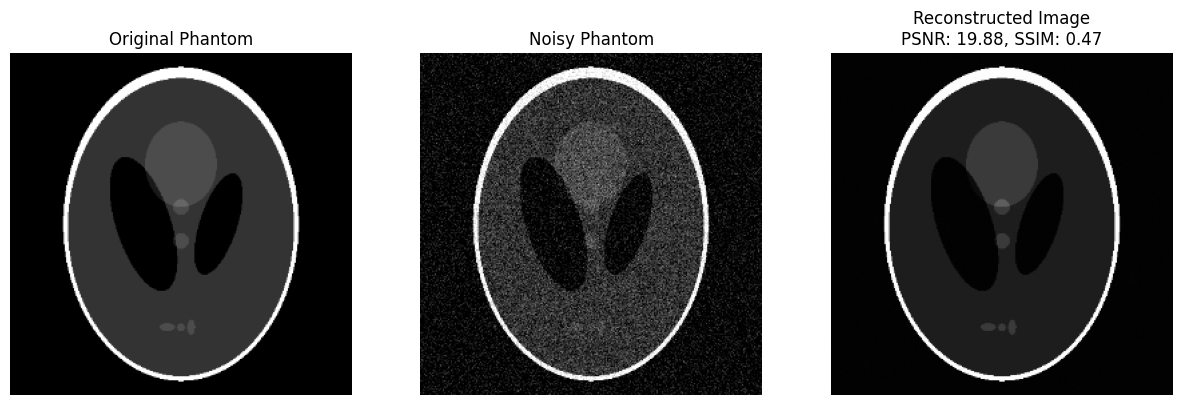

In [8]:
if __name__ == "__main__":
    main()